Making separate models for different Task IDs, repeating them several times and taking the average AUC.<br>
This model does not take into account second try.

In [1]:
import json
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow as tf
import pprint as pp
import math
import random
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filepath = "../data/student_vectors_n_task_10_n_limit_10000.json"
filepath2 = "../../../student_vectors_n_task_10_n_limit_100000.json"
student_vectors = json.load(open(filepath))
student_vectors2 = json.load(open(filepath2))

In [3]:
task_ids = []
for i in student_vectors:
    for j in student_vectors[i]:
        if j['task_id'] not in task_ids:
            task_ids.append(j['task_id'])
print("Number of unique task IDs: " + str(len(task_ids)))
print("Number of students: " + str(len(student_vectors)))

Number of unique task IDs: 10
Number of students: 1255


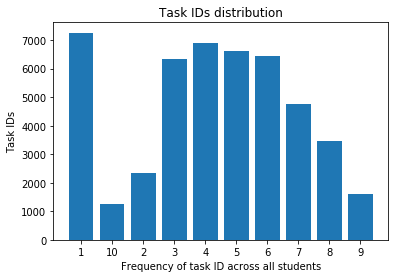

Task IDs mapping: 
Task ID -> p7cfRPp-kQ.partb(1) is attempted 7259 times. Max seq len: 46
Task ID -> Ok-iIHxjgx.partb(2) is attempted 2325 times. Max seq len: 27
Task ID -> 1zsCldT4p8.set1(3) is attempted 6346 times. Max seq len: 39
Task ID -> DebcfZEEmI.proper_fractions(4) is attempted 6897 times. Max seq len: 40
Task ID -> 9wRCzK1G7F.partb(5) is attempted 6632 times. Max seq len: 43
Task ID -> 1zsCldT4p8.set2(6) is attempted 6443 times. Max seq len: 28
Task ID -> nl-M69Ez9k.parta(7) is attempted 4753 times. Max seq len: 56
Task ID -> kvig7fcCVc.partb(8) is attempted 3473 times. Max seq len: 32
Task ID -> Ok-iIHxjgx.parta(9) is attempted 1589 times. Max seq len: 39
Task ID -> hyei4uD81i.parta(10) is attempted 1255 times. Max seq len: 40


In [4]:
#frequency distribution of taskids
cnt2 = Counter()
another_2 = {}
seqlen_tasks = {}
temp_seqlen = {}
position_2 = 1
for i in student_vectors:
    for k in temp_seqlen:
        temp_seqlen[k] = 0
    for j in student_vectors[i]:
        if(j['second_try'] == False):
            if j['task_id'] not in another_2:
                another_2[j['task_id']] = str(position_2)
                position_2 = position_2 + 1
            if j['task_id'] not in seqlen_tasks:
                seqlen_tasks[j['task_id']] = []

            if j['task_id'] not in temp_seqlen:
                temp_seqlen[j['task_id']] = 1
            else:
                temp_seqlen[j['task_id']] += 1
            cnt2[another_2[j['task_id']]] += 1
    for k in seqlen_tasks:
        seqlen_tasks[k].append(temp_seqlen[k])
plt.bar(cnt2.keys(), cnt2.values())
plt.title("Task IDs distribution")
plt.xlabel("Frequency of task ID across all students")
plt.ylabel("Task IDs")
plt.show()
print("Task IDs mapping: ")
for i in another_2:
    print("Task ID -> "+str(i)+"("+str(another_2[i])+") is attempted " + str(cnt2[another_2[i]]) + " times." + " Max seq len: "+str(max(seqlen_tasks[i])))

In [5]:
split = int(0.8*len(student_vectors))
print(split)

1004


In [6]:
proportion_right_train = {}
proportion_right_test = {}
proportion_wrong_train = {}
proportion_wrong_test = {}
num_of_students_train = {}
num_of_students_test = {}

for k in another_2:
    proportion_right_train[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    proportion_right_test[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    proportion_wrong_train[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    proportion_wrong_test[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    num_of_students_train[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    num_of_students_test[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    for idx,i in enumerate(student_vectors):
        if(idx<split): #training set
            question_number = 0
            right_wrong = []
            did_student_attempt = False
            for j in student_vectors[i]:
                if(j['second_try'] == False and j['task_id'] == k):
                    question_number += 1
                    did_student_attempt = True
                    if(j['correct'] == True):
                        right_wrong.append('right')
                    else:
                        right_wrong.append('wrong')
            if(did_student_attempt):
                for l in range(question_number):
                    num_of_students_train[k][l] += 1
                    if(right_wrong[l] == 'right'):
                        proportion_right_train[k][l] += 1
        else: #test set
            question_number = 0
            right_wrong = []
            did_student_attempt = False
            for j in student_vectors[i]:
                if(j['second_try'] == False and j['task_id'] == k):
                    question_number += 1
                    did_student_attempt = True
                    if(j['correct'] == True):
                        right_wrong.append('right')
                    else:
                        right_wrong.append('wrong')
            if(did_student_attempt):
                for l in range(question_number):
                    num_of_students_test[k][l] += 1
                    if(right_wrong[l] == 'right'):
                        proportion_right_test[k][l] += 1
    for g in range(max(seqlen_tasks[k])):
        proportion_right_train[k][g] = round((proportion_right_train[k][g]) / (num_of_students_train[k][g]),4)
        proportion_right_test[k][g] = round((proportion_right_test[k][g]) / (num_of_students_test[k][g]),4)
        proportion_wrong_train[k][g] = round(1.0 - proportion_right_train[k][g],4)
        proportion_wrong_test[k][g] = round(1.0 - proportion_right_test[k][g],4)        

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


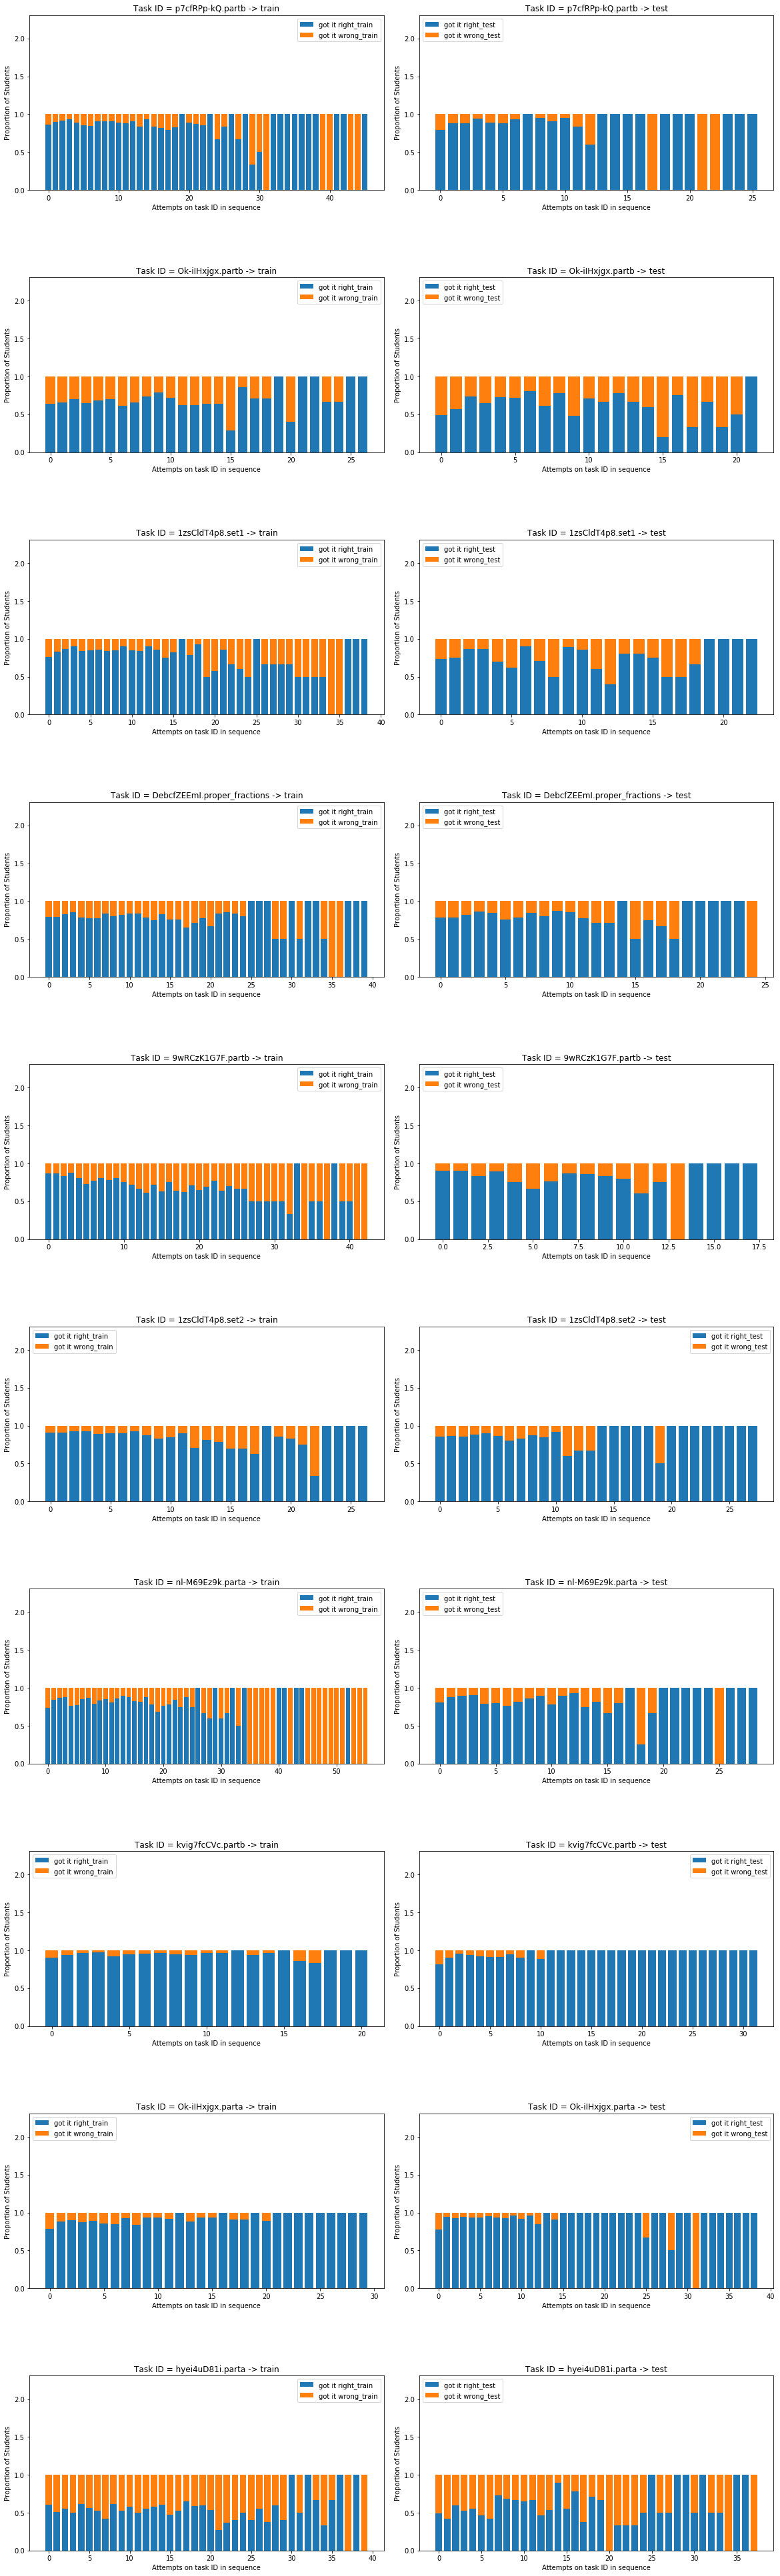

In [8]:
fig, axs = plt.subplots(10,2, figsize=(20, 70), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.10)

axs = axs.ravel()
for i,value in enumerate(another_2):
    N = max(seqlen_tasks[value])
    ind = np.arange(N)
    for k in ['train','test']:
        if(k=='train'):
            axs[2*i].bar(ind,proportion_right_train[value],label="got it right_train")
            axs[2*i].bar(ind,proportion_wrong_train[value],bottom = proportion_right_train[value],label="got it wrong_train")
            axs[2*i].set_ylim(0,2.31)
            axs[2*i].legend(loc="best") 
            axs[2*i].set_xlabel("Attempts on task ID in sequence")
            axs[2*i].set_ylabel("Proportion of Students")
            axs[2*i].set_title("Task ID = "+str(value) + " -> " + str(k))
        else:
            axs[2*i+1].bar(ind,proportion_right_test[value],label="got it right_test")
            axs[2*i+1].bar(ind,proportion_wrong_test[value],bottom = proportion_right_test[value],label="got it wrong_test")
            axs[2*i+1].set_ylim(0,2.31)
            axs[2*i+1].legend(loc="best") 
            axs[2*i+1].set_xlabel("Attempts on task ID in sequence")
            axs[2*i+1].set_ylabel("Proportion of Students")
            axs[2*i+1].set_title("Task ID = "+str(value) + " -> " + str(k))
plt.savefig('proportions_right_wrong.png')

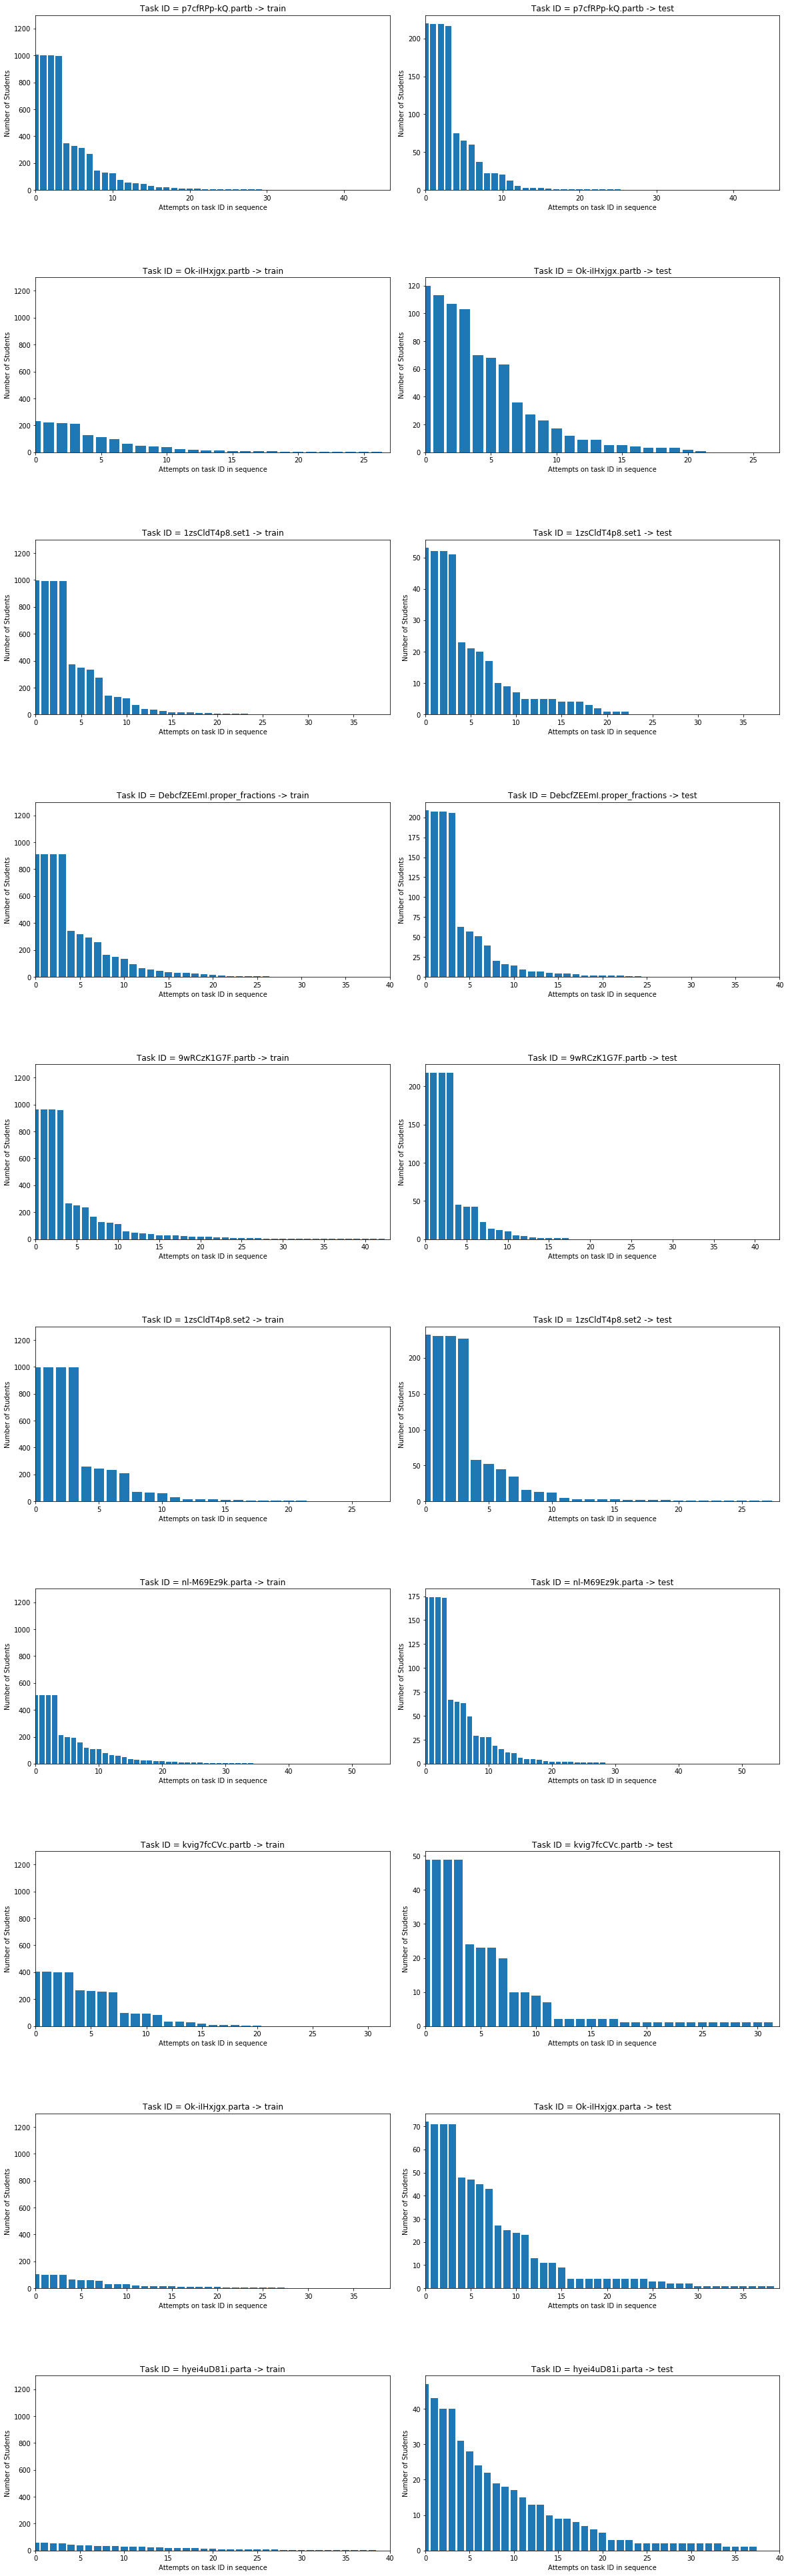

In [9]:
fig, axs = plt.subplots(10,2, figsize=(20, 70), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.1)

axs = axs.ravel()

for i,value in enumerate(another_2):
    N = max(seqlen_tasks[value])
    ind = np.arange(N)
    for k in ['train','test']:
        if k=='train':
            axs[2*i].bar(ind,num_of_students_train[value])
            axs[2*i].set_ylim(0,1300)
            axs[2*i].set_xlim(0,max(seqlen_tasks[value]))
            axs[2*i].set_xlabel("Attempts on task ID in sequence")
            axs[2*i].set_ylabel("Number of Students")
            axs[2*i].set_title("Task ID = "+str(value) + " -> " + k)
        else:
            axs[2*i+1].bar(ind,num_of_students_test[value])
            #axs[2*i+1].set_ylim(0,1300)
            axs[2*i+1].set_xlim(0,max(seqlen_tasks[value]))
            axs[2*i+1].set_xlabel("Attempts on task ID in sequence")
            axs[2*i+1].set_ylabel("Number of Students")
            axs[2*i+1].set_title("Task ID = "+str(value) + " -> " + k)
plt.savefig('num_students.png')

In [10]:
test_AUC_all_tasks = {}
train_AUC_all_tasks = {}
for i in another_2:
    print("\n\n\nCalculating for Task ID: "+str(i)+" which has the frequency: " + str(cnt2[another_2[i]]) + "\n")
    train_AUC_taski = []
    test_AUC_taski = []
    len_vector = 1
    #make sequences
    sequences = []
    sequences_lengths = []
    for p in student_vectors:
        interactions = []
        interactions.append([0.]) #for getting the first prediction!
        for j in student_vectors[p]:
            if(j['task_id'] == i and j['second_try'] == False):
                if(j['correct'] == True):
                    interactions.append([1.])
                else:
                    interactions.append([0.])
        if(len(interactions) > 1):
            sequences_lengths.append(len(interactions))
            sequences.append(interactions)
            
    #add padding
    padded_sequences = np.zeros([len(sequences),max(sequences_lengths),len_vector])
    for p in range(len(sequences)):
        for j in range(len(sequences[p])):
            padded_sequences[p][j] = sequences[p][j]

    #split the train and test set like BKT
    split = int(0.8*len(sequences))
    train_x = padded_sequences[:split,:-1]
    train_y = padded_sequences[:split,1:]
    train_seqlen = sequences_lengths[:split]
    test_x = padded_sequences[split:,:-1]
    test_y = padded_sequences[split:,1:]
    test_seqlen = sequences_lengths[split:]
    
    #define hold-out set for early stopping

    num_units = 5
    l_rate = 0.01
    epochs = 1000
    display_ep = 20
    repeat = 1
    
    for r in range(repeat): #don't have to repeat results since we fixed the random state
        print("\n\n"+ str(r+1) +" out of "+ str(repeat) + " Time Run.")
        # build the network
        tf.reset_default_graph()
        tf.set_random_seed(1234) #fixing the random states for repeating results
        #placeholders
        x = tf.placeholder(tf.float32, [None, max(sequences_lengths)-1, len_vector])
        y = tf.placeholder(tf.float32, [None, max(sequences_lengths)-1, len_vector])
        seqlen_tf = tf.placeholder(tf.float32,[None])

        #dynamic RNN definition
        def dynamicRNN(x):
            rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
            outputs, states = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32,sequence_length=seqlen_tf)
            out_size = len_vector
            outputs = tf.contrib.layers.fully_connected(outputs, out_size, activation_fn = tf.nn.sigmoid, weights_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
            #outputs = tf.nn.sigmoid(outputs)
            return outputs

        pred = dynamicRNN(x)
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=y))
        optimizer = tf.train.AdamOptimizer(learning_rate=l_rate).minimize(cost)
        #optimizer = tf.train.MomentumOptimizer(learning_rate=l_rate,momentum=0.9).minimize(cost)
        auc_train,  opts_train = tf.metrics.auc(labels = y, predictions = pred, curve='ROC')
        auc_test,  opts_test = tf.metrics.auc(labels = y, predictions = pred, curve='ROC')

        #execute the network
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())
            stop = False
            epoch = 0
            cost_prev = 1.0
            while(stop == False):
            #for epoch in range(1, epochs+1):
                epoch += 1
                sess.run(optimizer, feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen})
                if epoch % display_ep == 0 or epoch == 1:
                    loss, trainAUC, trainOPTS = sess.run([cost,auc_train,opts_train], feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen})
                    testAUC, testOPTS = sess.run([auc_test,opts_test], feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen})
                    print("Epoch: " + str(epoch) +", cost: "+str(loss)+ ", train set AUC: " + str(trainOPTS) + ", test set AUC: "+ str(testOPTS) +";")
                    train_AUC_taski.append(trainOPTS)
                    test_AUC_taski.append(testOPTS)
                    cost_current = loss
                    if cost_prev - cost_current <= 0.00005:
                        stop = True
                    else:
                        cost_prev = cost_current
            
            view_point = np.argmax(test_seqlen)
            prediction = sess.run([pred], feed_dict={x: [test_x[view_point]], y: [test_y[view_point]], seqlen_tf: [test_seqlen[view_point]]})
            #view_point = len(test_x) - 1 
            view_point = np.argmax(test_seqlen)
            print("\n\ntrue:\n")
            print(test_x[view_point][:test_seqlen[view_point]])
            print("\n\nprediction\n")
            print(prediction[0])
            
    test_AUC_all_tasks[i] = train_AUC_taski
    train_AUC_all_tasks[i] = test_AUC_taski




Calculating for Task ID: p7cfRPp-kQ.partb which has the frequency: 7259



1 out of 1 Time Run.
Epoch: 1, cost: 0.9134377, train set AUC: 0.885664, test set AUC: 0.877334;
Epoch: 20, cost: 0.8871798, train set AUC: 0.91563374, test set AUC: 0.9131102;
Epoch: 40, cost: 0.8606838, train set AUC: 0.94946295, test set AUC: 0.94868;
Epoch: 60, cost: 0.83690125, train set AUC: 0.9619029, test set AUC: 0.9616046;
Epoch: 80, cost: 0.81587595, train set AUC: 0.9677788, test set AUC: 0.9676814;
Epoch: 100, cost: 0.79741216, train set AUC: 0.97106165, test set AUC: 0.97107387;
Epoch: 120, cost: 0.7816174, train set AUC: 0.9730989, test set AUC: 0.9731725;
Epoch: 140, cost: 0.7681301, train set AUC: 0.97447693, test set AUC: 0.97457653;
Epoch: 160, cost: 0.756668, train set AUC: 0.9753881, test set AUC: 0.9755111;
Epoch: 180, cost: 0.74689305, train set AUC: 0.97615504, test set AUC: 0.97628564;
Epoch: 200, cost: 0.7385982, train set AUC: 0.97685164, test set AUC: 0.9769889;
Epoch: 220, cost: 0

Epoch: 280, cost: 0.7128046, train set AUC: 0.7177383, test set AUC: 0.7335562;
Epoch: 300, cost: 0.7099216, train set AUC: 0.721269, test set AUC: 0.7366559;
Epoch: 320, cost: 0.70649654, train set AUC: 0.72613996, test set AUC: 0.7399351;
Epoch: 340, cost: 0.7039205, train set AUC: 0.73161274, test set AUC: 0.74406385;
Epoch: 360, cost: 0.7012251, train set AUC: 0.73548806, test set AUC: 0.7468511;
Epoch: 380, cost: 0.6989827, train set AUC: 0.7389458, test set AUC: 0.74947846;
Epoch: 400, cost: 0.6970355, train set AUC: 0.7417886, test set AUC: 0.7517127;
Epoch: 420, cost: 0.6951408, train set AUC: 0.7442535, test set AUC: 0.7537123;
Epoch: 440, cost: 0.693557, train set AUC: 0.7465, test set AUC: 0.755446;
Epoch: 460, cost: 0.6921049, train set AUC: 0.7488221, test set AUC: 0.75721;
Epoch: 480, cost: 0.6907985, train set AUC: 0.7510123, test set AUC: 0.7587833;
Epoch: 500, cost: 0.6896486, train set AUC: 0.75305533, test set AUC: 0.7601746;
Epoch: 520, cost: 0.6889973, train set AU

Epoch: 360, cost: 0.69631606, train set AUC: 0.9087685, test set AUC: 0.9124464;
Epoch: 380, cost: 0.6940468, train set AUC: 0.908566, test set AUC: 0.91214585;
Epoch: 400, cost: 0.69198644, train set AUC: 0.9083928, test set AUC: 0.9118708;
Epoch: 420, cost: 0.6907585, train set AUC: 0.9082764, test set AUC: 0.91169256;
Epoch: 440, cost: 0.68928736, train set AUC: 0.90845317, test set AUC: 0.91175455;
Epoch: 460, cost: 0.68851763, train set AUC: 0.9087847, test set AUC: 0.9120558;
Epoch: 480, cost: 0.686319, train set AUC: 0.90869623, test set AUC: 0.9119445;
Epoch: 500, cost: 0.6848933, train set AUC: 0.9089363, test set AUC: 0.9121317;
Epoch: 520, cost: 0.6840981, train set AUC: 0.9094823, test set AUC: 0.91249555;
Epoch: 540, cost: 0.68281835, train set AUC: 0.909372, test set AUC: 0.9123602;
Epoch: 560, cost: 0.6817376, train set AUC: 0.9093568, test set AUC: 0.9123201;
Epoch: 580, cost: 0.6808425, train set AUC: 0.9093377, test set AUC: 0.9122905;
Epoch: 600, cost: 0.6799673, tra

Epoch: 1, cost: 0.8863867, train set AUC: 0.85722125, test set AUC: 0.8477349;
Epoch: 20, cost: 0.8620215, train set AUC: 0.8912934, test set AUC: 0.88586324;
Epoch: 40, cost: 0.8355359, train set AUC: 0.9330487, test set AUC: 0.9281437;
Epoch: 60, cost: 0.810812, train set AUC: 0.9505091, test set AUC: 0.9449715;
Epoch: 80, cost: 0.7881373, train set AUC: 0.9465143, test set AUC: 0.94179606;
Epoch: 100, cost: 0.7654592, train set AUC: 0.94954807, test set AUC: 0.9436939;
Epoch: 120, cost: 0.74701387, train set AUC: 0.9505157, test set AUC: 0.9437068;
Epoch: 140, cost: 0.7330387, train set AUC: 0.95055974, test set AUC: 0.9428882;
Epoch: 160, cost: 0.72180486, train set AUC: 0.9504141, test set AUC: 0.9420322;
Epoch: 180, cost: 0.71252877, train set AUC: 0.9501007, test set AUC: 0.94112915;
Epoch: 200, cost: 0.7047398, train set AUC: 0.94970304, test set AUC: 0.9402537;
Epoch: 220, cost: 0.6980707, train set AUC: 0.9493645, test set AUC: 0.93960387;
Epoch: 240, cost: 0.69252545, train 

Epoch: 20, cost: 0.82326406, train set AUC: 0.92138416, test set AUC: 0.9184928;
Epoch: 40, cost: 0.79687864, train set AUC: 0.9466977, test set AUC: 0.9464876;
Epoch: 60, cost: 0.7751754, train set AUC: 0.95600003, test set AUC: 0.9567352;
Epoch: 80, cost: 0.7565053, train set AUC: 0.9602696, test set AUC: 0.96145105;
Epoch: 100, cost: 0.74036014, train set AUC: 0.96266127, test set AUC: 0.9640403;
Epoch: 120, cost: 0.7265162, train set AUC: 0.9641588, test set AUC: 0.9656813;
Epoch: 140, cost: 0.7147316, train set AUC: 0.9649629, test set AUC: 0.9665344;
Epoch: 160, cost: 0.7047743, train set AUC: 0.9656217, test set AUC: 0.96725994;
Epoch: 180, cost: 0.6963306, train set AUC: 0.966136, test set AUC: 0.9678191;
Epoch: 200, cost: 0.689205, train set AUC: 0.96650785, test set AUC: 0.9682335;
Epoch: 220, cost: 0.6831481, train set AUC: 0.9669045, test set AUC: 0.968664;
Epoch: 240, cost: 0.67796785, train set AUC: 0.96721303, test set AUC: 0.96899843;
Epoch: 260, cost: 0.67352474, train

Epoch: 180, cost: 0.71057487, train set AUC: 0.9685665, test set AUC: 0.9701423;
Epoch: 200, cost: 0.7030876, train set AUC: 0.96887904, test set AUC: 0.97032505;
Epoch: 220, cost: 0.6967128, train set AUC: 0.9691873, test set AUC: 0.9704481;
Epoch: 240, cost: 0.69117224, train set AUC: 0.96954244, test set AUC: 0.970559;
Epoch: 260, cost: 0.686461, train set AUC: 0.96978503, test set AUC: 0.9705855;
Epoch: 280, cost: 0.68241477, train set AUC: 0.9699667, test set AUC: 0.9705895;
Epoch: 300, cost: 0.6789108, train set AUC: 0.9701104, test set AUC: 0.97056985;
Epoch: 320, cost: 0.67585135, train set AUC: 0.97021276, test set AUC: 0.97053593;
Epoch: 340, cost: 0.67316616, train set AUC: 0.97029436, test set AUC: 0.9704867;
Epoch: 360, cost: 0.67078394, train set AUC: 0.9703653, test set AUC: 0.97043455;
Epoch: 380, cost: 0.6686821, train set AUC: 0.97045916, test set AUC: 0.97043246;
Epoch: 400, cost: 0.6667971, train set AUC: 0.97054434, test set AUC: 0.9704367;
Epoch: 420, cost: 0.6651

Epoch: 680, cost: 0.6965114, train set AUC: 0.56704247, test set AUC: 0.60402966;
Epoch: 700, cost: 0.6957604, train set AUC: 0.57079625, test set AUC: 0.6085433;
Epoch: 720, cost: 0.6947532, train set AUC: 0.57412404, test set AUC: 0.6125141;
Epoch: 740, cost: 0.6931994, train set AUC: 0.57695985, test set AUC: 0.6158205;
Epoch: 760, cost: 0.6939574, train set AUC: 0.5787978, test set AUC: 0.6160192;


true:

[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


prediction

[[[1.3559085e-03]
  [8.5063547e-02]
  [4.8136421e-02]
  [1.6505003e-04]
  [3.5305841e-06]
  [8.2562218e-07]
  [2.8361214e-06]
  [1.7037914e-06]
  [9.7425311e-07]
  [7.4023587e-06]
  [7.2871875e-03]
  [1.4591448e-01]
  [1.5356457e-01]
  [3.0378137e-02]
  [3.5166927e-02]
  [4.8095635e-03]
  [2.2418091e-04]
  [7.9694119e-06]
  [1.4401227e-06]
  [4.8382736e-07]
 

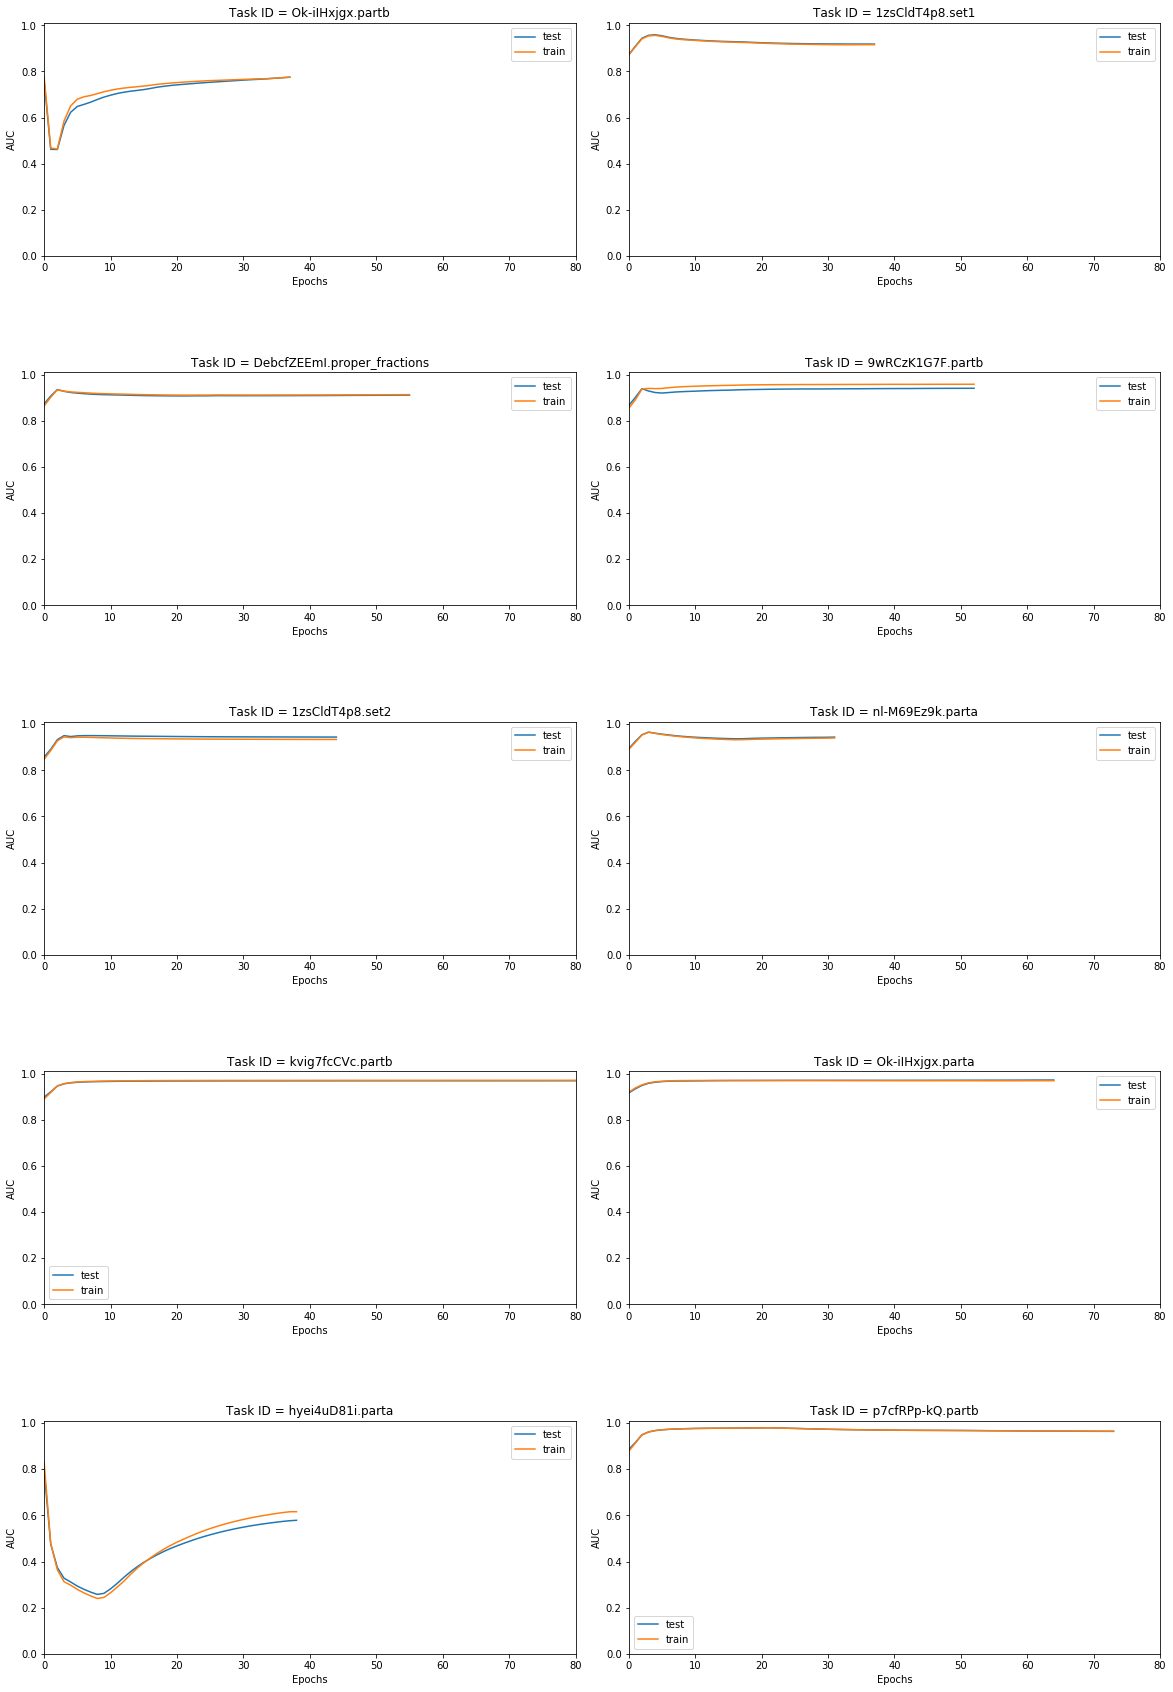

In [13]:
fig, axs = plt.subplots(5,2, figsize=(20, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.1)

axs = axs.ravel()

for i,value in enumerate(another_2):
    axs[i-1].plot(test_AUC_all_tasks[value],label='test')
    axs[i-1].plot(train_AUC_all_tasks[value],label='train')
    axs[i-1].set_ylim(0,1.01)
    axs[i-1].set_xlim(0,80)
    axs[i-1].set_xlabel("Epochs")
    axs[i-1].set_ylabel("AUC")
    axs[i-1].legend(loc="best")
    axs[i-1].set_title("Task ID = "+str(value))

In [14]:
for i in another_2:
    print(i + " final train acc: " + str(round(train_AUC_all_tasks[i][-1],3)) + "; final test acc: "+str(round(test_AUC_all_tasks[i][-1],3)))

p7cfRPp-kQ.partb final train acc: 0.965; final test acc: 0.964
Ok-iIHxjgx.partb final train acc: 0.775; final test acc: 0.775
1zsCldT4p8.set1 final train acc: 0.916; final test acc: 0.919
DebcfZEEmI.proper_fractions final train acc: 0.914; final test acc: 0.912
9wRCzK1G7F.partb final train acc: 0.959; final test acc: 0.941
1zsCldT4p8.set2 final train acc: 0.934; final test acc: 0.944
nl-M69Ez9k.parta final train acc: 0.94; final test acc: 0.944
kvig7fcCVc.partb final train acc: 0.971; final test acc: 0.969
Ok-iIHxjgx.parta final train acc: 0.969; final test acc: 0.973
hyei4uD81i.parta final train acc: 0.616; final test acc: 0.579
